In [1]:
import numpy as np
from sklearn.datasets import load_digits
from scipy.spatial.distance import pdist
from sklearn.manifold.t_sne import _joint_probabilities
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.manifold.t_sne module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.manifold. Anything that cannot be imported from sklearn.manifold is now part of the private API.
  warnings.warn(message, FutureWarning)


In [67]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 20)

In [3]:
X, y = load_digits(return_X_y=True)

In [27]:
y

array([0, 1, 2, ..., 8, 9, 8])

In [53]:
MACHINE_EPSILON = np.finfo(np.double).eps
n_components = 2
perplexity = 60

In [54]:
def _tsne(P, degrees_of_freedom, n_samples, X_embedded):
    params = X_embedded.ravel()
    
    obj_func = _kl_divergence
    
    params = _gradient_descent(obj_func, params, [P, degrees_of_freedom, n_samples, n_components])
        
    X_embedded = params.reshape(n_samples, n_components)
    return X_embedded

In [55]:
def fit(X):
    n_samples = X.shape[0]
    
    # Compute euclidean distance
    distances = pairwise_distances(X, metric='euclidean', squared=True)
    
    # Compute joint probabilities p_ij from distances.
    P = _joint_probabilities(distances=distances, desired_perplexity=perplexity, verbose=False)
    
    # The embedding is initialized with iid samples from Gaussians with standard deviation 1e-4.
    X_embedded = 1e-4 * np.random.mtrand._rand.randn(n_samples, n_components).astype(np.float32)
    
    # degrees_of_freedom = n_components - 1 comes from
    # "Learning a Parametric Embedding by Preserving Local Structure"
    # Laurens van der Maaten, 2009.
    degrees_of_freedom = max(n_components - 1, 1)
    
    return _tsne(P, degrees_of_freedom, n_samples, X_embedded=X_embedded)

In [56]:
def _kl_divergence(params, P, degrees_of_freedom, n_samples, n_components):
    X_embedded = params.reshape(n_samples, n_components)
    
    dist = pdist(X_embedded, "sqeuclidean")
    dist /= degrees_of_freedom
    dist += 1.
    dist **= (degrees_of_freedom + 1.0) / -2.0
    Q = np.maximum(dist / (2.0 * np.sum(dist)), MACHINE_EPSILON)
    
    # Kullback-Leibler divergence of P and Q
    kl_divergence = 2.0 * np.dot(P, np.log(np.maximum(P, MACHINE_EPSILON) / Q))
    
    # Gradient: dC/dY
    grad = np.ndarray((n_samples, n_components), dtype=params.dtype)
    PQd = squareform((P - Q) * dist)
    for i in range(n_samples):
        grad[i] = np.dot(np.ravel(PQd[i], order='K'),
                         X_embedded[i] - X_embedded)
    grad = grad.ravel()
    c = 2.0 * (degrees_of_freedom + 1.0) / degrees_of_freedom
    grad *= c
    return kl_divergence, grad

In [57]:
def _gradient_descent(obj_func, p0, args, it=0, n_iter=1000,
                      n_iter_check=1, n_iter_without_progress=300,
                      momentum=0.8, learning_rate=200.0, min_gain=0.01,
                      min_grad_norm=1e-7):
    
    p = p0.copy().ravel()
    update = np.zeros_like(p)
    gains = np.ones_like(p)
    error = np.finfo(np.float).max
    best_error = np.finfo(np.float).max
    best_iter = i = it
    
    for i in range(it, n_iter):
        error, grad = obj_func(p, *args)
        grad_norm = linalg.norm(grad)
        inc = update * grad < 0.0
        dec = np.invert(inc)
        gains[inc] += 0.2
        gains[dec] *= 0.8
        np.clip(gains, min_gain, np.inf, out=gains)
        grad *= gains
        update = momentum * update - learning_rate * grad
        p += update
        print("[t-SNE] Iteration %d: error = %.7f,"
                      " gradient norm = %.7f"
                      % (i + 1, error, grad_norm))
        
        if error < best_error:
                best_error = error
                best_iter = i
        elif i - best_iter > n_iter_without_progress:
            break
        
        if grad_norm <= min_grad_norm:
            break
    return p

In [58]:
X_embedded = fit(X)

[t-SNE] Iteration 1: error = 3.3595383, gradient norm = 0.0000041
[t-SNE] Iteration 2: error = 3.3595383, gradient norm = 0.0000041
[t-SNE] Iteration 3: error = 3.3595382, gradient norm = 0.0000049
[t-SNE] Iteration 4: error = 3.3595382, gradient norm = 0.0000071
[t-SNE] Iteration 5: error = 3.3595382, gradient norm = 0.0000117
[t-SNE] Iteration 6: error = 3.3595381, gradient norm = 0.0000207
[t-SNE] Iteration 7: error = 3.3595377, gradient norm = 0.0000390
[t-SNE] Iteration 8: error = 3.3595363, gradient norm = 0.0000780
[t-SNE] Iteration 9: error = 3.3595300, gradient norm = 0.0001643
[t-SNE] Iteration 10: error = 3.3594990, gradient norm = 0.0003635
[t-SNE] Iteration 11: error = 3.3593337, gradient norm = 0.0008410
[t-SNE] Iteration 12: error = 3.3583761, gradient norm = 0.0020174
[t-SNE] Iteration 13: error = 3.3525245, gradient norm = 0.0048787
[t-SNE] Iteration 14: error = 3.3180908, gradient norm = 0.0108487
[t-SNE] Iteration 15: error = 3.1691000, gradient norm = 0.0172182
[t-S

[t-SNE] Iteration 125: error = 0.7447823, gradient norm = 0.0003387
[t-SNE] Iteration 126: error = 0.7437569, gradient norm = 0.0003276
[t-SNE] Iteration 127: error = 0.7427518, gradient norm = 0.0003224
[t-SNE] Iteration 128: error = 0.7417659, gradient norm = 0.0003075
[t-SNE] Iteration 129: error = 0.7407985, gradient norm = 0.0002945
[t-SNE] Iteration 130: error = 0.7398503, gradient norm = 0.0002954
[t-SNE] Iteration 131: error = 0.7389170, gradient norm = 0.0002949
[t-SNE] Iteration 132: error = 0.7379997, gradient norm = 0.0002849
[t-SNE] Iteration 133: error = 0.7370986, gradient norm = 0.0002854
[t-SNE] Iteration 134: error = 0.7362107, gradient norm = 0.0002828
[t-SNE] Iteration 135: error = 0.7353355, gradient norm = 0.0002711
[t-SNE] Iteration 136: error = 0.7344723, gradient norm = 0.0002651
[t-SNE] Iteration 137: error = 0.7336211, gradient norm = 0.0002624
[t-SNE] Iteration 138: error = 0.7327807, gradient norm = 0.0002583
[t-SNE] Iteration 139: error = 0.7319503, gradie

[t-SNE] Iteration 246: error = 0.6788918, gradient norm = 0.0001860
[t-SNE] Iteration 247: error = 0.6785562, gradient norm = 0.0001996
[t-SNE] Iteration 248: error = 0.6782186, gradient norm = 0.0001962
[t-SNE] Iteration 249: error = 0.6778697, gradient norm = 0.0002299
[t-SNE] Iteration 250: error = 0.6774374, gradient norm = 0.0002778
[t-SNE] Iteration 251: error = 0.6770078, gradient norm = 0.0002534
[t-SNE] Iteration 252: error = 0.6769010, gradient norm = 0.0004198
[t-SNE] Iteration 253: error = 0.6765475, gradient norm = 0.0003567
[t-SNE] Iteration 254: error = 0.6762275, gradient norm = 0.0002439
[t-SNE] Iteration 255: error = 0.6760762, gradient norm = 0.0002847
[t-SNE] Iteration 256: error = 0.6758684, gradient norm = 0.0002817
[t-SNE] Iteration 257: error = 0.6756168, gradient norm = 0.0002709
[t-SNE] Iteration 258: error = 0.6753466, gradient norm = 0.0002577
[t-SNE] Iteration 259: error = 0.6750911, gradient norm = 0.0002077
[t-SNE] Iteration 260: error = 0.6749071, gradie

[t-SNE] Iteration 368: error = 0.6614489, gradient norm = 0.0000693
[t-SNE] Iteration 369: error = 0.6613902, gradient norm = 0.0000702
[t-SNE] Iteration 370: error = 0.6613318, gradient norm = 0.0000701
[t-SNE] Iteration 371: error = 0.6612738, gradient norm = 0.0000714
[t-SNE] Iteration 372: error = 0.6612160, gradient norm = 0.0000723
[t-SNE] Iteration 373: error = 0.6611584, gradient norm = 0.0000707
[t-SNE] Iteration 374: error = 0.6611012, gradient norm = 0.0000695
[t-SNE] Iteration 375: error = 0.6610441, gradient norm = 0.0000711
[t-SNE] Iteration 376: error = 0.6609874, gradient norm = 0.0000677
[t-SNE] Iteration 377: error = 0.6609310, gradient norm = 0.0000662
[t-SNE] Iteration 378: error = 0.6608748, gradient norm = 0.0000728
[t-SNE] Iteration 379: error = 0.6608187, gradient norm = 0.0000700
[t-SNE] Iteration 380: error = 0.6607628, gradient norm = 0.0000661
[t-SNE] Iteration 381: error = 0.6607071, gradient norm = 0.0000671
[t-SNE] Iteration 382: error = 0.6606514, gradie

[t-SNE] Iteration 490: error = 0.6557760, gradient norm = 0.0000507
[t-SNE] Iteration 491: error = 0.6557390, gradient norm = 0.0000530
[t-SNE] Iteration 492: error = 0.6557020, gradient norm = 0.0000514
[t-SNE] Iteration 493: error = 0.6556652, gradient norm = 0.0000513
[t-SNE] Iteration 494: error = 0.6556284, gradient norm = 0.0000553
[t-SNE] Iteration 495: error = 0.6555918, gradient norm = 0.0000577
[t-SNE] Iteration 496: error = 0.6555552, gradient norm = 0.0000620
[t-SNE] Iteration 497: error = 0.6555186, gradient norm = 0.0000598
[t-SNE] Iteration 498: error = 0.6554820, gradient norm = 0.0000516
[t-SNE] Iteration 499: error = 0.6554455, gradient norm = 0.0000527
[t-SNE] Iteration 500: error = 0.6554092, gradient norm = 0.0000564
[t-SNE] Iteration 501: error = 0.6553728, gradient norm = 0.0000536
[t-SNE] Iteration 502: error = 0.6553367, gradient norm = 0.0000545
[t-SNE] Iteration 503: error = 0.6553006, gradient norm = 0.0000608
[t-SNE] Iteration 504: error = 0.6552647, gradie

[t-SNE] Iteration 611: error = 0.6516832, gradient norm = 0.0000491
[t-SNE] Iteration 612: error = 0.6516504, gradient norm = 0.0000488
[t-SNE] Iteration 613: error = 0.6516176, gradient norm = 0.0000507
[t-SNE] Iteration 614: error = 0.6515848, gradient norm = 0.0000536
[t-SNE] Iteration 615: error = 0.6515518, gradient norm = 0.0000533
[t-SNE] Iteration 616: error = 0.6515189, gradient norm = 0.0000576
[t-SNE] Iteration 617: error = 0.6514859, gradient norm = 0.0000640
[t-SNE] Iteration 618: error = 0.6514529, gradient norm = 0.0000647
[t-SNE] Iteration 619: error = 0.6514195, gradient norm = 0.0000519
[t-SNE] Iteration 620: error = 0.6513863, gradient norm = 0.0000566
[t-SNE] Iteration 621: error = 0.6513530, gradient norm = 0.0000569
[t-SNE] Iteration 622: error = 0.6513196, gradient norm = 0.0000524
[t-SNE] Iteration 623: error = 0.6512862, gradient norm = 0.0000568
[t-SNE] Iteration 624: error = 0.6512527, gradient norm = 0.0000559
[t-SNE] Iteration 625: error = 0.6512191, gradie

[t-SNE] Iteration 733: error = 0.6470049, gradient norm = 0.0000610
[t-SNE] Iteration 734: error = 0.6469641, gradient norm = 0.0000632
[t-SNE] Iteration 735: error = 0.6469235, gradient norm = 0.0000588
[t-SNE] Iteration 736: error = 0.6468831, gradient norm = 0.0000595
[t-SNE] Iteration 737: error = 0.6468430, gradient norm = 0.0000598
[t-SNE] Iteration 738: error = 0.6468033, gradient norm = 0.0000645
[t-SNE] Iteration 739: error = 0.6467638, gradient norm = 0.0000671
[t-SNE] Iteration 740: error = 0.6467247, gradient norm = 0.0000704
[t-SNE] Iteration 741: error = 0.6466856, gradient norm = 0.0000631
[t-SNE] Iteration 742: error = 0.6466469, gradient norm = 0.0000601
[t-SNE] Iteration 743: error = 0.6466086, gradient norm = 0.0000659
[t-SNE] Iteration 744: error = 0.6465704, gradient norm = 0.0000626
[t-SNE] Iteration 745: error = 0.6465324, gradient norm = 0.0000617
[t-SNE] Iteration 746: error = 0.6464948, gradient norm = 0.0000618
[t-SNE] Iteration 747: error = 0.6464574, gradie

[t-SNE] Iteration 855: error = 0.6433892, gradient norm = 0.0000519
[t-SNE] Iteration 856: error = 0.6433632, gradient norm = 0.0000696
[t-SNE] Iteration 857: error = 0.6433366, gradient norm = 0.0000592
[t-SNE] Iteration 858: error = 0.6433104, gradient norm = 0.0000626
[t-SNE] Iteration 859: error = 0.6432839, gradient norm = 0.0000517
[t-SNE] Iteration 860: error = 0.6432577, gradient norm = 0.0000611
[t-SNE] Iteration 861: error = 0.6432313, gradient norm = 0.0000474
[t-SNE] Iteration 862: error = 0.6432053, gradient norm = 0.0000616
[t-SNE] Iteration 863: error = 0.6431790, gradient norm = 0.0000471
[t-SNE] Iteration 864: error = 0.6431531, gradient norm = 0.0000565
[t-SNE] Iteration 865: error = 0.6431270, gradient norm = 0.0000503
[t-SNE] Iteration 866: error = 0.6431009, gradient norm = 0.0000535
[t-SNE] Iteration 867: error = 0.6430748, gradient norm = 0.0000487
[t-SNE] Iteration 868: error = 0.6430486, gradient norm = 0.0000538
[t-SNE] Iteration 869: error = 0.6430223, gradie

[t-SNE] Iteration 977: error = 0.6394849, gradient norm = 0.0000697
[t-SNE] Iteration 978: error = 0.6394388, gradient norm = 0.0000629
[t-SNE] Iteration 979: error = 0.6393921, gradient norm = 0.0000628
[t-SNE] Iteration 980: error = 0.6393447, gradient norm = 0.0000716
[t-SNE] Iteration 981: error = 0.6392966, gradient norm = 0.0000783
[t-SNE] Iteration 982: error = 0.6392478, gradient norm = 0.0000901
[t-SNE] Iteration 983: error = 0.6391981, gradient norm = 0.0000831
[t-SNE] Iteration 984: error = 0.6391476, gradient norm = 0.0000709
[t-SNE] Iteration 985: error = 0.6390968, gradient norm = 0.0000721
[t-SNE] Iteration 986: error = 0.6390455, gradient norm = 0.0000747
[t-SNE] Iteration 987: error = 0.6389937, gradient norm = 0.0000871
[t-SNE] Iteration 988: error = 0.6389411, gradient norm = 0.0000744
[t-SNE] Iteration 989: error = 0.6388883, gradient norm = 0.0000713
[t-SNE] Iteration 990: error = 0.6388352, gradient norm = 0.0000820
[t-SNE] Iteration 991: error = 0.6387814, gradie

/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

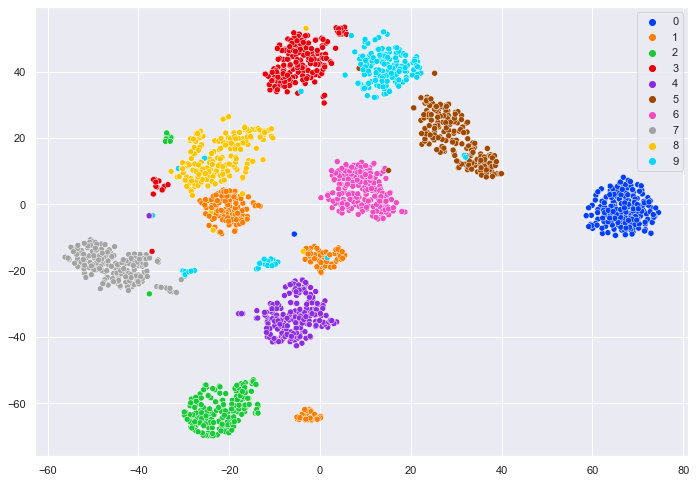

In [61]:
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full', palette=palette)

In [62]:
from scipy.io import loadmat

def load_descriptor_from_matfile(ft_path,lab_path):
    feat = loadmat(ft_path)
    feat = feat['features']
    lab = loadmat(lab_path)
    lab = lab['labels']
    return feat, lab


In [64]:
trf = '../../../features_for_python_4_opponent_phow/phow_4_' + str(450) +'_rbf/training_features.mat'
trlab = '../../../features_for_python_4_opponent_phow/phow_4_' + str(450) +'_rbf/training_lab_features.mat'


training_feat,tr_lab = load_descriptor_from_matfile(trf, trlab)


In [65]:
X_embedded = fit(training_feat)

[t-SNE] Iteration 1: error = 2.8446057, gradient norm = 0.0000052
[t-SNE] Iteration 2: error = 2.8446057, gradient norm = 0.0000051
[t-SNE] Iteration 3: error = 2.8446057, gradient norm = 0.0000067
[t-SNE] Iteration 4: error = 2.8446056, gradient norm = 0.0000112
[t-SNE] Iteration 5: error = 2.8446056, gradient norm = 0.0000206
[t-SNE] Iteration 6: error = 2.8446052, gradient norm = 0.0000411
[t-SNE] Iteration 7: error = 2.8446038, gradient norm = 0.0000880
[t-SNE] Iteration 8: error = 2.8445964, gradient norm = 0.0002016
[t-SNE] Iteration 9: error = 2.8445528, gradient norm = 0.0004916
[t-SNE] Iteration 10: error = 2.8442668, gradient norm = 0.0012679
[t-SNE] Iteration 11: error = 2.8421889, gradient norm = 0.0034053
[t-SNE] Iteration 12: error = 2.8265759, gradient norm = 0.0087895
[t-SNE] Iteration 13: error = 2.7353615, gradient norm = 0.0166413
[t-SNE] Iteration 14: error = 2.4757130, gradient norm = 0.0189401
[t-SNE] Iteration 15: error = 2.1494221, gradient norm = 0.0138539
[t-S

[t-SNE] Iteration 126: error = 0.9959721, gradient norm = 0.0002666
[t-SNE] Iteration 127: error = 0.9955079, gradient norm = 0.0002582
[t-SNE] Iteration 128: error = 0.9950510, gradient norm = 0.0002552
[t-SNE] Iteration 129: error = 0.9945980, gradient norm = 0.0002499
[t-SNE] Iteration 130: error = 0.9941485, gradient norm = 0.0002484
[t-SNE] Iteration 131: error = 0.9937012, gradient norm = 0.0002454
[t-SNE] Iteration 132: error = 0.9932563, gradient norm = 0.0002411
[t-SNE] Iteration 133: error = 0.9928142, gradient norm = 0.0002320
[t-SNE] Iteration 134: error = 0.9923756, gradient norm = 0.0002273
[t-SNE] Iteration 135: error = 0.9919399, gradient norm = 0.0002255
[t-SNE] Iteration 136: error = 0.9915053, gradient norm = 0.0002249
[t-SNE] Iteration 137: error = 0.9910707, gradient norm = 0.0002143
[t-SNE] Iteration 138: error = 0.9906413, gradient norm = 0.0002131
[t-SNE] Iteration 139: error = 0.9902153, gradient norm = 0.0002111
[t-SNE] Iteration 140: error = 0.9897894, gradie

[t-SNE] Iteration 249: error = 0.9630132, gradient norm = 0.0000611
[t-SNE] Iteration 250: error = 0.9629612, gradient norm = 0.0000617
[t-SNE] Iteration 251: error = 0.9629097, gradient norm = 0.0000595
[t-SNE] Iteration 252: error = 0.9628587, gradient norm = 0.0000601
[t-SNE] Iteration 253: error = 0.9628080, gradient norm = 0.0000601
[t-SNE] Iteration 254: error = 0.9627577, gradient norm = 0.0000612
[t-SNE] Iteration 255: error = 0.9627077, gradient norm = 0.0000675
[t-SNE] Iteration 256: error = 0.9626577, gradient norm = 0.0000681
[t-SNE] Iteration 257: error = 0.9626075, gradient norm = 0.0000612
[t-SNE] Iteration 258: error = 0.9625574, gradient norm = 0.0000585
[t-SNE] Iteration 259: error = 0.9625071, gradient norm = 0.0000639
[t-SNE] Iteration 260: error = 0.9624560, gradient norm = 0.0000621
[t-SNE] Iteration 261: error = 0.9624037, gradient norm = 0.0000624
[t-SNE] Iteration 262: error = 0.9623498, gradient norm = 0.0000661
[t-SNE] Iteration 263: error = 0.9622931, gradie

[t-SNE] Iteration 371: error = 0.9577542, gradient norm = 0.0000267
[t-SNE] Iteration 372: error = 0.9577451, gradient norm = 0.0000244
[t-SNE] Iteration 373: error = 0.9577364, gradient norm = 0.0000256
[t-SNE] Iteration 374: error = 0.9577279, gradient norm = 0.0000249
[t-SNE] Iteration 375: error = 0.9577196, gradient norm = 0.0000230
[t-SNE] Iteration 376: error = 0.9577116, gradient norm = 0.0000236
[t-SNE] Iteration 377: error = 0.9577038, gradient norm = 0.0000224
[t-SNE] Iteration 378: error = 0.9576962, gradient norm = 0.0000221
[t-SNE] Iteration 379: error = 0.9576888, gradient norm = 0.0000218
[t-SNE] Iteration 380: error = 0.9576816, gradient norm = 0.0000210
[t-SNE] Iteration 381: error = 0.9576745, gradient norm = 0.0000212
[t-SNE] Iteration 382: error = 0.9576675, gradient norm = 0.0000206
[t-SNE] Iteration 383: error = 0.9576607, gradient norm = 0.0000208
[t-SNE] Iteration 384: error = 0.9576540, gradient norm = 0.0000199
[t-SNE] Iteration 385: error = 0.9576475, gradie

[t-SNE] Iteration 494: error = 0.9554017, gradient norm = 0.0000409
[t-SNE] Iteration 495: error = 0.9553951, gradient norm = 0.0000402
[t-SNE] Iteration 496: error = 0.9553887, gradient norm = 0.0000391
[t-SNE] Iteration 497: error = 0.9553823, gradient norm = 0.0000382
[t-SNE] Iteration 498: error = 0.9553759, gradient norm = 0.0000378
[t-SNE] Iteration 499: error = 0.9553695, gradient norm = 0.0000372
[t-SNE] Iteration 500: error = 0.9553629, gradient norm = 0.0000368
[t-SNE] Iteration 501: error = 0.9553560, gradient norm = 0.0000367
[t-SNE] Iteration 502: error = 0.9553487, gradient norm = 0.0000372
[t-SNE] Iteration 503: error = 0.9553407, gradient norm = 0.0000386
[t-SNE] Iteration 504: error = 0.9553319, gradient norm = 0.0000401
[t-SNE] Iteration 505: error = 0.9553218, gradient norm = 0.0000419
[t-SNE] Iteration 506: error = 0.9553106, gradient norm = 0.0000432
[t-SNE] Iteration 507: error = 0.9552982, gradient norm = 0.0000438
[t-SNE] Iteration 508: error = 0.9552856, gradie

[t-SNE] Iteration 617: error = 0.9550177, gradient norm = 0.0000067
[t-SNE] Iteration 618: error = 0.9550168, gradient norm = 0.0000068
[t-SNE] Iteration 619: error = 0.9550160, gradient norm = 0.0000068
[t-SNE] Iteration 620: error = 0.9550152, gradient norm = 0.0000068
[t-SNE] Iteration 621: error = 0.9550144, gradient norm = 0.0000068
[t-SNE] Iteration 622: error = 0.9550135, gradient norm = 0.0000068
[t-SNE] Iteration 623: error = 0.9550127, gradient norm = 0.0000067
[t-SNE] Iteration 624: error = 0.9550119, gradient norm = 0.0000066
[t-SNE] Iteration 625: error = 0.9550111, gradient norm = 0.0000066
[t-SNE] Iteration 626: error = 0.9550103, gradient norm = 0.0000065
[t-SNE] Iteration 627: error = 0.9550095, gradient norm = 0.0000064
[t-SNE] Iteration 628: error = 0.9550088, gradient norm = 0.0000064
[t-SNE] Iteration 629: error = 0.9550080, gradient norm = 0.0000063
[t-SNE] Iteration 630: error = 0.9550072, gradient norm = 0.0000063
[t-SNE] Iteration 631: error = 0.9550064, gradie

[t-SNE] Iteration 740: error = 0.9549493, gradient norm = 0.0000043
[t-SNE] Iteration 741: error = 0.9549489, gradient norm = 0.0000042
[t-SNE] Iteration 742: error = 0.9549486, gradient norm = 0.0000042
[t-SNE] Iteration 743: error = 0.9549483, gradient norm = 0.0000041
[t-SNE] Iteration 744: error = 0.9549480, gradient norm = 0.0000040
[t-SNE] Iteration 745: error = 0.9549477, gradient norm = 0.0000040
[t-SNE] Iteration 746: error = 0.9549473, gradient norm = 0.0000040
[t-SNE] Iteration 747: error = 0.9549470, gradient norm = 0.0000040
[t-SNE] Iteration 748: error = 0.9549467, gradient norm = 0.0000040
[t-SNE] Iteration 749: error = 0.9549464, gradient norm = 0.0000039
[t-SNE] Iteration 750: error = 0.9549461, gradient norm = 0.0000039
[t-SNE] Iteration 751: error = 0.9549458, gradient norm = 0.0000039
[t-SNE] Iteration 752: error = 0.9549455, gradient norm = 0.0000038
[t-SNE] Iteration 753: error = 0.9549452, gradient norm = 0.0000038
[t-SNE] Iteration 754: error = 0.9549449, gradie

[t-SNE] Iteration 863: error = 0.9549233, gradient norm = 0.0000025
[t-SNE] Iteration 864: error = 0.9549232, gradient norm = 0.0000025
[t-SNE] Iteration 865: error = 0.9549231, gradient norm = 0.0000025
[t-SNE] Iteration 866: error = 0.9549230, gradient norm = 0.0000025
[t-SNE] Iteration 867: error = 0.9549228, gradient norm = 0.0000025
[t-SNE] Iteration 868: error = 0.9549227, gradient norm = 0.0000025
[t-SNE] Iteration 869: error = 0.9549226, gradient norm = 0.0000025
[t-SNE] Iteration 870: error = 0.9549225, gradient norm = 0.0000025
[t-SNE] Iteration 871: error = 0.9549223, gradient norm = 0.0000025
[t-SNE] Iteration 872: error = 0.9549222, gradient norm = 0.0000025
[t-SNE] Iteration 873: error = 0.9549221, gradient norm = 0.0000024
[t-SNE] Iteration 874: error = 0.9549220, gradient norm = 0.0000025
[t-SNE] Iteration 875: error = 0.9549219, gradient norm = 0.0000026
[t-SNE] Iteration 876: error = 0.9549218, gradient norm = 0.0000029
[t-SNE] Iteration 877: error = 0.9549217, gradie

[t-SNE] Iteration 985: error = 0.9549135, gradient norm = 0.0000016
[t-SNE] Iteration 986: error = 0.9549134, gradient norm = 0.0000016
[t-SNE] Iteration 987: error = 0.9549134, gradient norm = 0.0000015
[t-SNE] Iteration 988: error = 0.9549134, gradient norm = 0.0000016
[t-SNE] Iteration 989: error = 0.9549133, gradient norm = 0.0000016
[t-SNE] Iteration 990: error = 0.9549133, gradient norm = 0.0000016
[t-SNE] Iteration 991: error = 0.9549132, gradient norm = 0.0000016
[t-SNE] Iteration 992: error = 0.9549132, gradient norm = 0.0000015
[t-SNE] Iteration 993: error = 0.9549131, gradient norm = 0.0000016
[t-SNE] Iteration 994: error = 0.9549131, gradient norm = 0.0000016
[t-SNE] Iteration 995: error = 0.9549130, gradient norm = 0.0000015
[t-SNE] Iteration 996: error = 0.9549130, gradient norm = 0.0000015
[t-SNE] Iteration 997: error = 0.9549129, gradient norm = 0.0000015
[t-SNE] Iteration 998: error = 0.9549129, gradient norm = 0.0000015
[t-SNE] Iteration 999: error = 0.9549129, gradie

/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

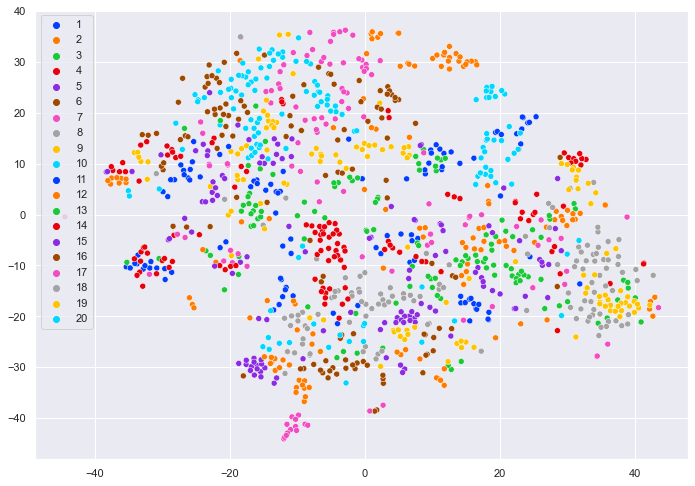

In [68]:
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=tt, legend='full', palette=palette)

In [43]:
tt  = tr_lab.reshape(-1)

In [44]:
tt.shape

(1200,)

In [50]:
import numpy as np
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=3).fit_transform(training_feat)
X_embedded.shape

(1200, 3)

/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

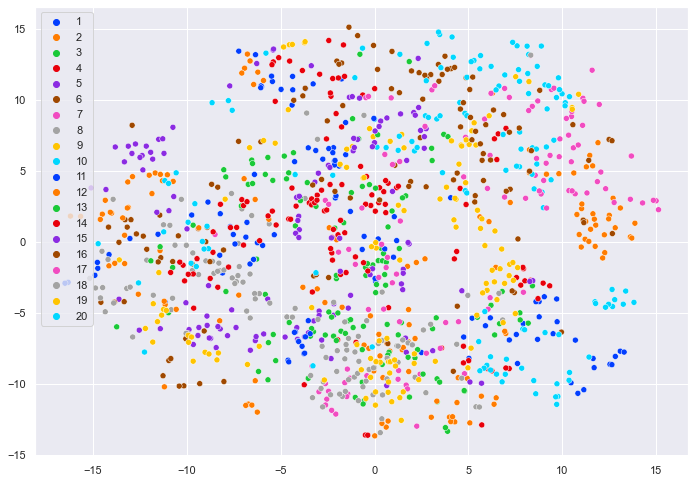

In [52]:
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=tt, legend='full', palette=palette)

In [74]:
import sys
sys.path.append('/Users/admin/Desktop/tesi/Thesis/')

from handcrafted_descriptors.descriptor import binary_gabor_features as bgf

import os

def getPath_and_dict(path, train):
    lichens = os.listdir(path)
    dic_lic = {}
    res = []
    for i,l in enumerate(lichens):
        dic_lic[l] = i
        pth = os.path.join(path,l)
        images_of_specific_lichen = os.listdir(pth)
        for j,im in enumerate(images_of_specific_lichen):
            image = os.path.join(pth,im)
            res.append(image)
    
    
    if(train is True):
        np.random.shuffle(res)
    return res, dic_lic


def readimage(im):
    img = cv2.imread(im)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img




def getDescriptors(img, halflength = 15):
    img_r = img[:,:,0]
    img_g = img[:,:,1]
    img_b = img[:,:,2]   
    feat_1 = bgf.BGF(img_r, 200,200,50, halflngt = halflength, all = True)
    feat_2 = bgf.BGF(img_g, 200,200,50, halflngt = halflength, all = True)
    feat_3 = bgf.BGF(img_b, 200,200,50, halflngt = halflength, all = True)
    res = np.concatenate([feat_1, feat_2, feat_3])
    return res 

def extract_descriptors(path,train = False):
    images_pth, label_dict = getPath_and_dict(path, train)
    descriptor_list = [] 
    
    
    train_labels = []
    image_count = len(images_pth) 
    for i,img_path in enumerate(images_pth):
        cl = img_path.split('/')[-2]
        class_index = cl
        train_labels.append(class_index)        
        img = readimage(img_path)
        dsc = getDescriptors(img)
        if(i%100==0):
            print(dsc.shape)
        descriptor_list.append(dsc)     
    descriptors =np.array(descriptor_list)
    train_labels = np.array(train_labels)
    return descriptors, train_labels

In [ ]:
import cv2
tfeat,tlab = extract_descriptors('../../../data/train')

(648, 1)
